# CMSC320 Final Project: Steven Struglia, Michael Strobel, HtetMyat Aung

# Introduction:
The stock market is historically known as a near impossible system to solve, and continues to prove difficult as COVID-19 impacts the financial stability of the world, and more specifically the United States. A good measure of how the stock market is performing on a broad scale is the S&P500, a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. Being able to predict fluctuations and movement of the S&P500 on both a micro and macro level can generate massive profits for those that are investing their money correctly. 

The data that we're going to need for this project is the S&P 500 data (in this case we will be using the spy etf) as well as data from the top 10 companies in the S&P.

The top 10 companies as of 12.9.2020 are: AAPL, MSFT, AMZN, FB, GOOGL, GOOG, BRK.B, JNJ, JPM, V

The first thing that we need to do is import some data. For this, we will be using the AlphaVantage API.

In [ ]:
!pip install alpaca_trade_api

In [ ]:
import alpaca_trade_api as api
import pandas as pd
import time

# This is a personal API key that is used exclusively through this project. 
# Please do not abuse it and REMOVE before posting final demo online.
Key = "CH985KU0NJOWZAD7"

# This function returns the short and long SMA, RSI, and ADX techincal indicators wrapped in a dataframe along with the daily open, high, low, close, and volume.
def get_data (symbol = "spy", SMA_short_pd = 12, SMA_long_pd = 20, RSI_pd = 10, ADX_pd = 10):
    output = pd.DataFrame()
    # Getting the short timeframe simple moving average
    output = pd.read_csv("https://www.alphavantage.co/query?function=SMA&symbol="+ symbol +"&interval=daily&time_period=" + str(SMA_short_pd) + "&series_type=open&datatype=csv&apikey="+ Key)
    output = output.rename(columns = {'SMA':'short_SMA'})
    # Getting the long timeframe simple moving average
    output['long_SMA'] = pd.read_csv("https://www.alphavantage.co/query?function=SMA&symbol="+ symbol +"&interval=daily&time_period=" + str(SMA_long_pd) + "&series_type=open&datatype=csv&apikey="+ Key)['SMA']
    # Getting the Relative Strength Index
    output['RSI'] = pd.read_csv("https://www.alphavantage.co/query?function=RSI&symbol="+ symbol +"&interval=daily&time_period=" + str(RSI_pd) + "&series_type=open&datatype=csv&apikey=" + Key)['RSI']
    # Getting the Average Directional Index
    output['ADX'] = pd.read_csv("https://www.alphavantage.co/query?function=ADX&symbol="+ symbol +"&interval=daily&time_period=" + str(ADX_pd) + "&datatype=csv&apikey=" + Key)['ADX']
    # Getting the daliy price data and volumne
    output[['open','high','low','close','volume']] = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + symbol + '&outputsize=full&apikey=' + Key + '&datatype=csv')[['open','high','low','close','volume']]

    return output.dropna()

In [ ]:
# This function returns all of the data returned by get_data, for the top 10 S&P companies as well as SPY.
def get_top_data (SMA_short_pd = 12, SMA_long_pd = 20, RSI_pd = 10, ADX_pd = 10):
      symbol_list = ['SPY', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'BRK.B', 'JNJ', 'JPM', 'V']
 
      output = {}  
      for symbol in symbol_list:
            print(symbol)
            output[symbol] = get_data (symbol = symbol, SMA_short_pd = SMA_short_pd, SMA_long_pd = SMA_long_pd, RSI_pd = RSI_pd, ADX_pd = ADX_pd)
             # Sadly we have to add these in otherwise the API starts rejecting our calls 
            if symbol != 'v': time.sleep(60)   
  
      return output

In [ ]:
import os.path
from os import path, mkdir

# One of the problems with the API that we're using is that it is pretty slow. Because of this, we're going to store our data in a CSV to prevent further calls to it.
if not (path.exists("stock_data") and path.isdir('stock_data')):
    mkdir('stock_data')
    data_dict = get_top_data()
    for symbol, data in data_dict.items():
        name = "stock_data/" + str(symbol) + "_data.csv"
        data.to_csv(path_or_buf=name)

### Retrieve SPY Data from CSV's generated by functions above to return dataframe of metrics and stock ticker price/volume data

#### First, let us perform some EDA on just the daily returns using closing price data

In [1]:
import numpy as np
import glob
import re
import pandas as pd

# This table stores the closing prices for each of our tickers
close_price_table = pd.DataFrame()
for filepath in glob.iglob('stock_data/*.csv'):
    # Ignore the fundamental data
    if 'funda' in str(filepath):
        continue
    else:
        # Read and store the data for each ticker
        temp = pd.read_csv(filepath)
        start = 'stock_data/;'
        end = '_data.csv'
        s = filepath
        company = s[s.find(start)+len(start):s.rfind(end)]
        close_price_table[company] = temp['close']

# Adding a data column to our table. 
# Since all the API pulls happen at the same time, the data for each ticker has the same date.
close_price_table['date'] = pd.read_csv('stock_data/AAPL_data.csv')['time']
close_price_table = close_price_table.reindex(index=close_price_table.index[::-1]).reset_index()
close_price_table.drop('index', inplace=True, axis=1)
close_price_table.head()

,AAPL,AMZN,BRK.B,FB,GOOGL,GOOG,JNJ,JPM,MSFT,SPY,V,date
0,94.56,90.44,1874.0,NaN,NaN,NaN,105.10,76.94,90.19,140.9375,NaN,1999-11-29
1,97.87,85.06,1865.0,NaN,NaN,NaN,103.80,77.25,91.05,139.2812,NaN,1999-11-30
2,103.06,85.00,1860.0,NaN,NaN,NaN,102.50,77.39,93.19,140.4062,NaN,1999-12-01
3,110.19,89.06,1850.0,NaN,NaN,NaN,100.10,79.06,94.81,141.2500,NaN,1999-12-02
4,115.00,86.56,1840.0,NaN,NaN,NaN,97.25,82.00,96.12,143.8437,NaN,1999-12-03


## Exploratory Data Analysis

### Calculate percent change (daily return) and plot to confirm clean percent change distributions

$Percent \; Change_{t} = \frac{R_{t-1} - R_{t}}{R_{t}}$ on day $t$ where $R_{i}$ is the i'th day's rate of return

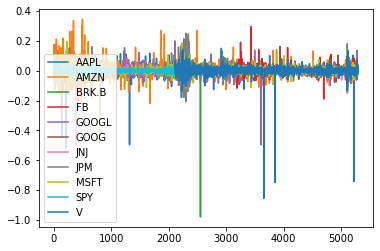

In [2]:
pct_change = close_price_table.drop('date',axis=1).pct_change()
pct_change.plot()

### Plot of cumulative returns for each ticker and SPY calculated using pandas.cumsum()

The cumulative sum at row $t$ is given by: $C_{t} = \sum_{i=1}^t PC_{t}$ where $PC_{i}$ is the the i'th day's percent change in daily returns

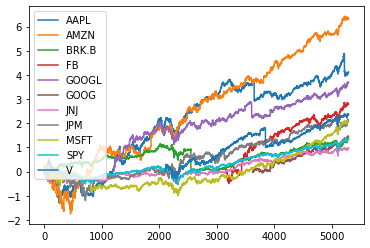

In [3]:
cumulative = pct_change.cumsum().plot()

### Distribution plot of daily returns grouped by year

We would like to predict how future price fluctuations are determined through an analysis of previous historical data. To understand how stock daily returns are distributed and behave, we would like to see a distribution plot of price change. This is done using a facet grid from seaborn, and gives us a great intuition of the univariate distributions as they are plotted year by year.

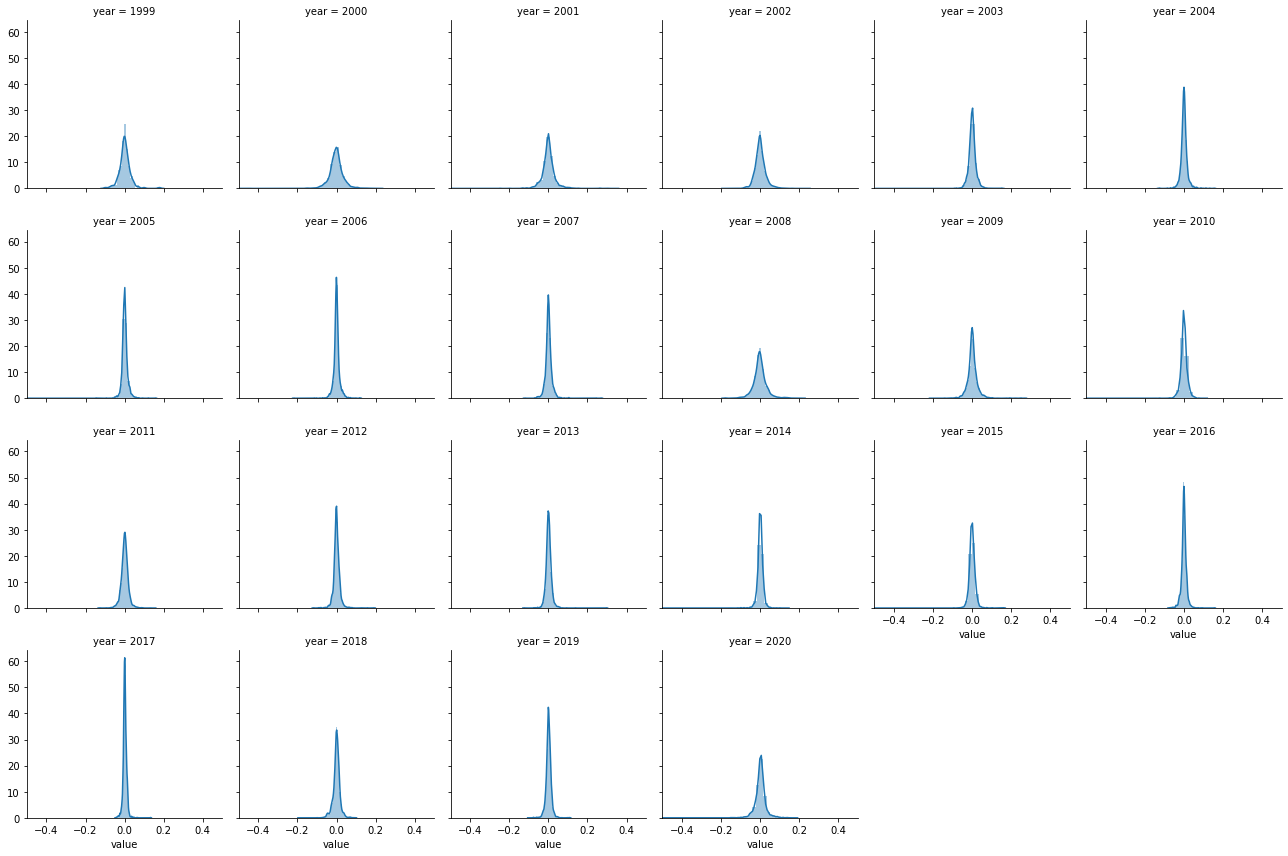

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Convert the year column to a datetime object for the plot
pct_change['year'] = pd.to_datetime(close_price_table['date']).dt.year
dfm = pct_change.melt('year')
g = sns.FacetGrid(dfm, col='year', col_wrap = 6)
g = (g.map(sns.distplot, 'value'))
plt.xlim(-0.5, 0.5)
plt.show()

We see from the above facet wrap of distributions that the daily return for each year centers around zero or just below it and that the daily returns are normally distributed. We can also see that the daily return standard deviation increases during financially turbulent years, such as 2008 during the Housing Crisis, and 2020 during the COVID-19 epidemic.

## Machine Learning Pipeline

Since we would like to see how fluctuations in price data of these top 10 stocks impacts the movement of the overall S&P500 market, we should categorize movement in S&P500 as rally, stressed, or neutral. If we observe that the fluctuations of the top 10 stocks' price data is statistically significantly impacting the S&P500 movement, it could help us determine which ones account for most of the movement. After ascertaining that there is a statistically significant correlation between the top 10 stocks and the S&P, we will build a feature set of technical indicators often used in the investment world: Short Simple Moving Average, Long Simple Moving Average, RSI (Relative Strength Index), and ADX (Average Directional Index) for each of our top 10 stocks and use these to predict movement in the S&P500. For the feature set of technical indicators, we will include the trend indicator, momentum indicator and volume indicator for multiple indicator strategy. After this we will compare the performance of multiple machine learning models with this prediction, along with cross-validation and hyper-parameter tuning of the models.

You can read more about multi-indicator strategy [here](https://tradingstrategyguides.com/best-combination-of-technical-indicators/#:~:text=Essentially%2C%20if%20you%20trade%20with,belong%20in%20the%20same%20category.&text=The%20best%20strategy%20multiple%20indicators,a%20different%20type%20of%20information.).

In [5]:
# This dataframe will store the timeseries of the indicators for each symbol.
feature_table = pd.DataFrame()

for filepath in glob.iglob('stock_data/*.csv'):
    # Ignore the fundamental data
    if 'funda' in str(filepath):
        continue
    else:
        # Read the features from each file into our feature_table dataframe
        temp = pd.read_csv(filepath)
        start = 'stock_data/;'
        end = '_data.csv'
        s = filepath
        # Getting the company name
        company = s[s.find(start)+len(start):s.rfind(end)]
        feature_table["{}_short_SMA".format(company)] = temp['short_SMA']
        feature_table["{}_long_SMA".format(company)] = temp['long_SMA']
        feature_table["{}_RSI".format(company)] = temp['RSI']
        feature_table["{}_ADX".format(company)] = temp['ADX']
        feature_table["{}_volume".format(company)] = temp['volume']
        
# Adding a data column to our table. 
# Since all the API pulls happen at the same time, the data for each ticker has the same date.
feature_table['date'] = pd.read_csv('stock_data/AAPL_data.csv')['time']
feature_table = feature_table.reindex(index=feature_table.index[::-1]).reset_index()
feature_table.drop('index', inplace=True, axis=1)
feature_table['SPY'] = pd.read_csv('stock_data/SPY_data.csv')['close'].pct_change()

print("Shape of feature set: {}".format(feature_table.shape))
feature_table.head()

Shape of feature set: (5294, 57)


,AAPL_short_SMA,AAPL_long_SMA,AAPL_RSI,AAPL_ADX,AAPL_volume,AMZN_short_SMA,AMZN_long_SMA,AMZN_RSI,AMZN_ADX,AMZN_volume,...,SPY_RSI,SPY_ADX,SPY_volume,V_short_SMA,V_long_SMA,V_RSI,V_ADX,V_volume,date,SPY
0,0.7059,0.6841,69.6198,73.2836,4144300,80.0017,75.7605,78.9287,66.9279,18053700,...,54.8075,42.9990,7348600,NaN,NaN,NaN,NaN,NaN,1999-11-29,NaN
1,0.7101,0.6911,75.4801,74.4192,7528400,81.1283,76.7710,63.8398,64.6212,13465500,...,54.1300,40.2926,7682000,NaN,NaN,NaN,NaN,NaN,1999-11-30,0.000327
2,0.7159,0.6999,78.8531,75.5028,5522900,82.2533,77.6460,61.9823,61.6103,10663600,...,46.7467,37.8569,6980200,NaN,NaN,NaN,NaN,NaN,1999-12-01,0.009050
3,0.7246,0.7082,80.9918,76.8714,5065700,83.1175,78.5365,59.6203,59.7269,9538700,...,53.2200,34.0955,6698300,NaN,NaN,NaN,NaN,NaN,1999-12-02,-0.002918
4,0.7388,0.7198,87.1631,78.3120,5785000,84.6383,79.8020,66.9067,58.4501,11151200,...,62.5043,34.7267,10045400,NaN,NaN,NaN,NaN,NaN,1999-12-03,0.002059


#### Labeler function for determining if the current S&P500 market is in a neutral market, stressed market, or rally market.

In [6]:
def labeler(x):
    # Here we use a daily positive change of .4% to specify rally.
    if x > 0.004:
        return "rally"
    # A change of -.4% specifies stressed,
    elif x < -0.004:
        return "stressed"
    # Otherwise, we will classify the market as neutral
    else:
        return "neutral"
        
feature_table['label'] = feature_table['SPY'].apply(labeler)
# Drop SPY daily returns from feature set
feature_table.drop('SPY', axis=1, inplace=True)
feature_table['label'].value_counts()

neutral     2143
stressed    1708
rally       1443
Name: label, dtype: int64

We see that the label distributions for neutral, stressed, and rally are fairly well-balanced and simulate a relatively realistic market condition distribution.

### Separate label and feature set and impute missing values

In [7]:
# Shift label by 1 day back so prediction will be predicting on the day after rather than predicting same-day classificaiton
feature_table['label'] = feature_table['label'].shift(-1)
# Because some indicators and tickers have a different shape, we will drop the NAs
feature_table = feature_table.dropna()

# Drop the label and date as they are not being used as features for our models.
X = feature_table.drop(['label','date'], axis=1)
y = feature_table['label']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (1671, 55)
Shape of y: (1671,)


We have 55 indicator features to input into our Classification models.

#### Category distribution of label column (S&P500 movement on any given day)

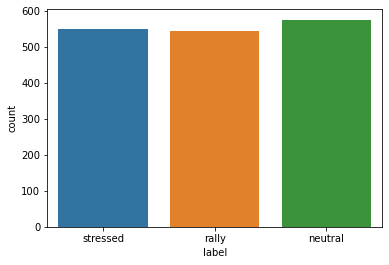

In [8]:
sns.countplot(feature_table['label'])

### Correlation Heatmaps of features for each separate indicator

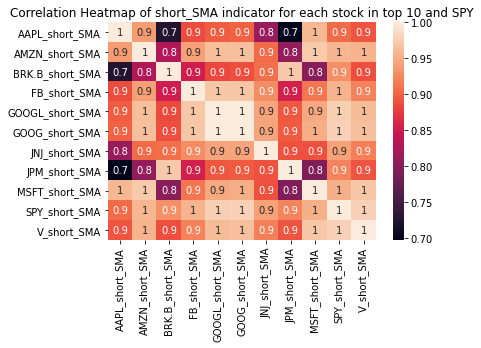

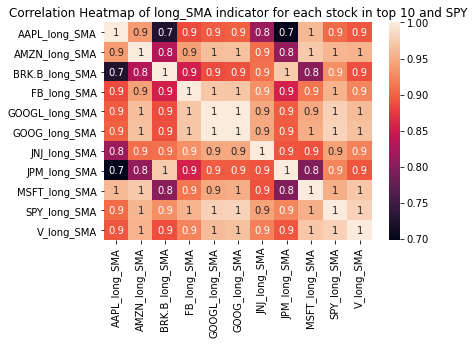

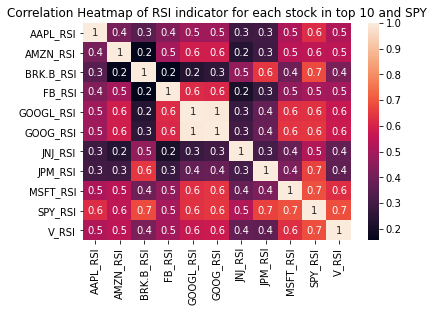

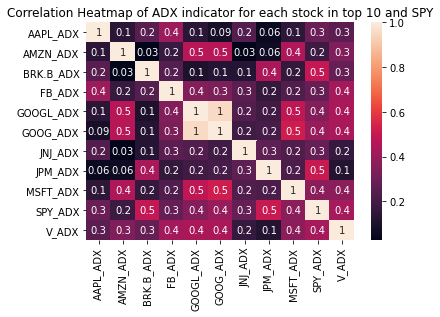

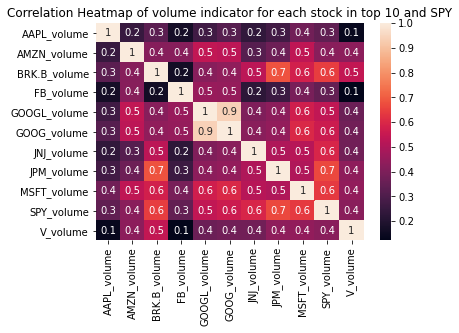

In [9]:
feature_list = ['short_SMA', 'long_SMA', 'RSI', 'ADX', 'volume']

for feat in feature_list:
    temp = X.filter(like=feat, axis=1)
    sns.heatmap(temp.corr(), annot=True, fmt='.1g')
    plt.title("Correlation Heatmap of {} indicator for each stock in top 10 and SPY".format(feat))
    plt.show()

From the correlation heatmaps, we see that the technical indicators of the top 10 stocks, in general, have a strong positive correlation with the associated indicator of the SPY index. Most notably, the two moving average and RSI features have a very strong positive correlation in comparison to ADX and volume. However, since they all demonstrate a power of explaining variance, we will keep all 5 indicator features for each stock to input into our machine learning classifiers.

### Comparison of Classification Model Performance for predicting 1-day future movement in S&P500 Index

We will be comparing the cross_val_score (mean of accuracies reported by 10-fold cross-validation) of 3 different classifiers: Random Forest, K-Nearest Neighbors, and Multilayer Perceptron in predicting 1-day future movement in the S&P500.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

cross_val_score(estimator, feature_set, target_variable, cross_validation_value) returns a list of 10 accuracy values (from a 10-fold cross-validation), which are then averaged to compute a single cross-validation score on each of the models.

In [11]:
classifier_names = ["Nearest Neighbors", "Random Forest", "Multilayer Perceptron"]
classifiers = [KNeighborsClassifier(), RandomForestClassifier(), MLPClassifier()]
print("--- Base Model Classifiers ---")
for name, clf in zip(classifier_names, classifiers):
    print("CV Score for {} Classifier: {}".format(name, np.mean(cross_val_score(clf, X, y, cv=10))))

--- Base Model Classifiers ---
CV Score for Nearest Neighbors Classifier: 0.32492158540062727
CV Score for Random Forest Classifier: 0.0764399771884802
CV Score for Multilayer Perceptron Classifier: 0.32191688052466494


We see that without any hyperparameter tuning, the Multilayer Perceptron classifier performs the best out of the three, with K-Nearest Neighbors falling closely behind and the Random Forest performing quite poorly. The Multilayer Perceptron and K-Nearest Neighbors classifiers were able to get just below a random chance guess (1/3 or 0.33333) accuracy for the prediction of the S&P500 movement.

### Hyperparameter Tuning

Hyperparameter tuning (or hyperparameter optimization) is the action of selecting optimal parameters for a machine learning estimator/model in order to gain additional predictive performance. A hyperparameter is a controlling factor in how a machine learning object is constructed, and needs to be optimally tuned in order to have the model optimally solve the problem. The traditional way of performing hyperparameter optimization has been grid search, or a parameter sweep, which is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. We implement a GridSearchCV (cross-validated grid search) object to optimially tune the hyperparameters of the K-Nearest Neighbors, Random Forest, and Multilayer Perceptron Classifiers. For more information regarding hyperparameter tuning specifically in the realm of scikit-learn, read more [here](https://scikit-learn.org/stable/modules/grid_search.html)

#### Hyperparameter Grid for K-Nearest Neighbors Classifier

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point. For more information regarding the parameters and intuition behind the K-Nearest Neighbors Algorithm: [K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

In [12]:
leaf_size = list(range(1,20))
n_neighbors = list(range(1,20))
p=[1,2]
#Convert to dictionary
parameter_space = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn = KNeighborsClassifier()
# Perform 10-fold cross-validated grid search on KNN hyperparameters
knn_clf = GridSearchCV(knn, parameter_space, n_jobs=-1, cv=10, verbose=1)
# Fit the grid search model
best_knn = knn_clf.fit(X,y).best_estimator_
print(best_knn)

Fitting 10 folds for each of 722 candidates, totalling 7220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3896 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 6096 tasks      | elapsed:   28.2s


KNeighborsClassifier(leaf_size=1, n_neighbors=1)


[Parallel(n_jobs=-1)]: Done 7220 out of 7220 | elapsed:   32.1s finished


#### Hyperparameter Grid for Random Forest Classifier

Random Forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. This makes it an "ensemble" of trees, that is a finite number of trees working to obtain better predictive performance than if we had only had one tree. A large number of relatively uncorrelated trees operating as a committee will outperform any of the individual constituent trees, as the trees protect each other from their individual errors. For more information about the parameters and intuition behind the Random Forest Algorithm: [Random Forest](https://en.wikipedia.org/wiki/Random_forest)

In [13]:
rfc = RandomForestClassifier()
parameter_space = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Perform 10-fold cross-validated grid search on random forest hyperparameters
rfc_clf = GridSearchCV(rfc,parameter_space, n_jobs=-1, cv=10, verbose=1)
# Fit the random search model
best_rfc = rfc_clf.fit(X, y).best_estimator_
print(best_rfc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  7.2min finished


RandomForestClassifier(max_depth=100, max_features=2, min_samples_leaf=4,
                       min_samples_split=12)


#### Hyperparameter Grid for Multilayer Perceptron Classifier

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function $f(\cdot): R^{m} \rightarrow R^{o}$
by training on a dataset, where  is the number of dimensions for input and  is the number of dimensions for output. Given a set of features $X = x_{1}, x_{2}, x_{3},....$
and a target $y$, it can learn a non-linear function approximator for either classification or regression. MLP trains using Backpropagation. More precisely, it trains using some form of gradient descent and the gradients are calculated using Backpropagation. For classification, it minimizes the Cross-Entropy loss function, giving a vector of probability estimates $P(y|x)$ per sample x. For more information about the MLP Classifier and Neural Networks in general, see: [Neural Networks and MLP Classifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

In [14]:
mlpc = MLPClassifier()
parameter_space = {
    'max_iter': [1500,2000,2500],
    'hidden_layer_sizes': list(zip(np.arange(10, 60, 10),np.arange(10, 60, 10))),
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': 10.0 ** -np.arange(1, 10, 2),
    'learning_rate': ['constant','adaptive']
}
# Perform 10-fold CV Grid Search over MLP parameter space to tune parameters
mlp_clf = GridSearchCV(mlpc, parameter_space, n_jobs=-1, cv=10, verbose=1)
# Fit the grid search model
best_mlp = mlp_clf.fit(X, y).best_estimator_
print(best_mlp)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 12.0min


MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(10, 10),
              learning_rate='adaptive', max_iter=1500)


[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 12.8min finished


### Comparison of Hyperparameter Tuned Classifiers:

In [15]:
hyperparameter_tuned_names = ['Best K-Nearest Neighbors', 'Best Random Forest', 'Best Multilayer Perceptron']
hyperparameter_tuned_classifiers = [best_knn, best_rfc, best_mlp]
print('--- Hyperparameter Tuned Classifier Scores ---')
for name, clf in zip(hyperparameter_tuned_names, hyperparameter_tuned_classifiers):
    print("CV Score for {} Classifier: {}".format(name, np.mean(cross_val_score(clf, X, y, cv=10))))

--- Hyperparameter Tuned Classifier Scores ---
CV Score for Best K-Nearest Neighbors Classifier: 0.33691545480467633
CV Score for Best Random Forest Classifier: 0.07823638437410892
CV Score for Best Multilayer Perceptron Classifier: 0.3716317365269461


We can see from the hyperparameter tuning scoring results that the Neural Network Classifier is the best classifier out of the three, with the score being a 0.37, slightly better than random guessing on the movement of the S&P500.

### Analysis of Multilayer Perceptron Classifier Performance

#### Plot of Confusion Matrix Heatmap to examine classifier performance based on label value

A confusion matrix represents the combinations of predictions and actual values for a machine learning classification model. Graphically, it shows how often the model corrently and incorrectly predicts a label/category based off of the true value.

In [16]:
from sklearn.metrics import confusion_matrix
def plot_confusion_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index= [i for i in ['Neutral', 'Rally', 'Stressed']], columns= [i for i in ['Neutral', 'Rally', 'Stressed']])
    ax = sns.heatmap(df_cm, cmap="Blues", annot=True, fmt = ".3g")
    ax.set(xlabel="Predicted Values", ylabel = "Actual Values")
    return ax

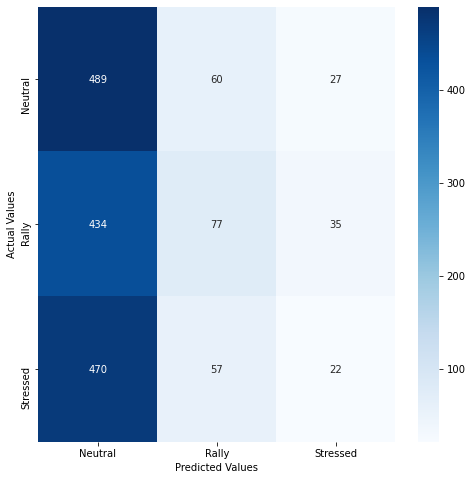

In [17]:
y_true = y
y_pred = best_mlp.predict(X)
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
fig = plot_confusion_heatmap(y_true, y_pred)
plt.show()

#### Plot of Learning and Scalability Curves for Neural Network Classifier

Learning curves demonstrate how a model's accuracy is impacted and changed by the number of training samples that are taken in for the input, and also display the scalability of a model by plotting its time to compute a fit on the input space as the input space gets larger.

In [18]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title("Learning curve for {} Classifier".format(title))
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

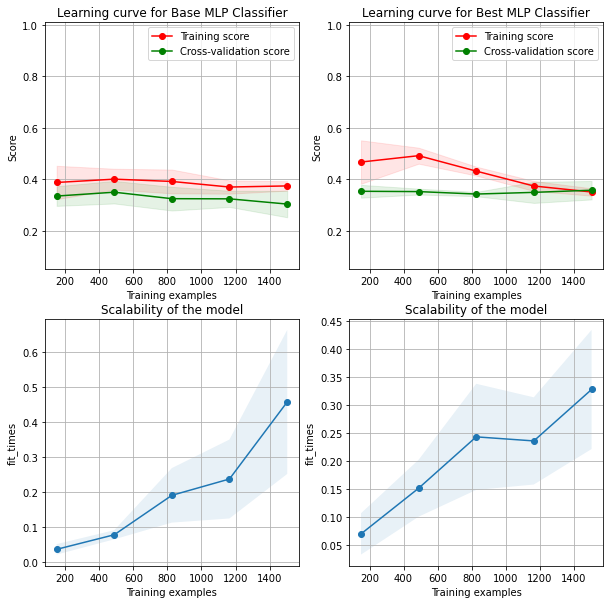

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plot_learning_curve(MLPClassifier(), "Base MLP", X, y, axes=axes[:, 0], ylim=(0.05, 1.01),
                    cv=10, n_jobs=-1)
plot_learning_curve(best_mlp, "Best MLP", X, y, axes=axes[:, 1], ylim=(0.05, 1.01),
                    cv=10, n_jobs=-1)
plt.show()

We can see from the learning curve of the MLP classifier that as training examples increased, the base MLP classifier model accuracy remained relatively stagnant across the graph. On the other hand, the hyperparameter tuned MLP classifier model accuracy dipped once it hit around 500 training examples, and converged with the cross-validation score to a CV-score of 0.37. The scalability of the model improved upon hyperparameter tuning, with it being around 75% of the time it would take to train the base model for a training size of 1400.

### Conclusion:

As we can see from the performance of the machine learning models, the stock market has proven to be a very tough system to solve. While there exists a massive amount of data for stocks and performance indicators, being able to predict next-day fluctuations in any stock, mutual fund, ETF, etc. proves to be a daunting task. A combination of trend, momentum, and volume indicators proved to be useful in predicting S&P500 1-day future movement better than a random guess with the use of a multilayer perceptron classifier. Hyperparameter tuning proved useful in increasing the predictive power of the multilayer perceptron classifier, with a cross-validation score increase of +0.05. 